<a href="https://colab.research.google.com/github/MinsooKwak/image_caption/blob/main/image_caption_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intro

이미지 처리를 위해서는 CNN 계열의 모델, 자연어 처리를 위해서는 RNN계열의 모델을 활용해 이미지를 캡션할 수 있다. 

최근 Transformer 기반의 모델들이 대두되고 SOTA를 기록하고 있는 것을 볼 수 있다. 

CNN 계열의 backbone을 고민하기에 앞서 이미지 처리에도 transformer를 활용한 ViT, SwinTransformer가 SOTA를 기록하고 있다. 

ViT가 이미지를 작은 patch들로 쪼개면서 많은 computational complexity를 기록함에 있어 SwinTrnaformer가 shifted window partitioning을 통해 window 내부에서만 patch들끼리 self-attention을 통해 ViT의 문제를 해결했지만, SwinTransformer의 경우 2021년 등장한 비교적 최신 모델이기 때문에 해당 프로젝트를 진행하기에는 추가적인 노력이 필요하다 생각되었다. 

이에 이전에 많이 사용된 ResNet 또는 Inception을 활용하는 것이 적합하다 생각되어 진행하고자 한다.

# Image Captioning Project

In [1]:
# 경고를 무시합니다.
import warnings
warnings.filterwarnings("ignore")

## Import Data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
root_directory = '/content/drive/MyDrive/ImageCaption/Data/flickr8k'

In [5]:
df = pd.read_csv('/content/drive/MyDrive/ImageCaption/Data/flickr8k/captions.txt')
df

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...
...,...,...
40450,997722733_0cb5439472.jpg,A man in a pink shirt climbs a rock face
40451,997722733_0cb5439472.jpg,A man is rock climbing high in the air .
40452,997722733_0cb5439472.jpg,A person in a red shirt climbing up a rock fac...
40453,997722733_0cb5439472.jpg,A rock climber in a red shirt .


In [6]:
df2 = pd.DataFrame(df.image.value_counts())
df2 = df2.reset_index()
df2

,index,image
0,1000268201_693b08cb0e.jpg,5
1,3388094307_5a83be64a5.jpg,5
2,3393394134_0caac47e1c.jpg,5
3,3393343330_b13df4d8ec.jpg,5
4,3393152604_27bd1037f2.jpg,5
...,...,...
8086,2699733386_c346c87ea6.jpg,5
8087,2699426519_228719b1db.jpg,5
8088,2699342860_5288e203ea.jpg,5
8089,2699125097_c6801d80ed.jpg,5


In [7]:
df2.image.value_counts()

5    8091
Name: image, dtype: int64

- 모든 이미지는 5개의 caption을 갖고 있음

## Tokeninzing

**영어 토큰화**

  > 특정한 구두점 문자를 대체하고 나머지 공백 문자를 기반으로 분할을 진행하는 keras tokenizer의 특성을 고려해 keras를 통한 토큰화 진행하기로 결정

- NLTK
  - 정규화 기반 (속도 빠름)
- spacy
  - 처리 속도는 NLTK, Keras 대비 낮으나 다른 성능 측면에서 우수
- **keras**
  - 정규화 기반 (속도 빠름)
  - 모든 토큰을 소문자로 변경
  - Don't를 don't로 Jone's를 jone's로 변경 
  - 마침표나 쉼표 등의 구두점은 버림

참고 : 
- https://mollymollang.tistory.com/18
- https://na0-0.tistory.com/67


전처리 패키지 (추가 참고) : https://datascienceschool.net/03%20machine%20learning/01.02%20%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D%EC%9A%A9%20%ED%8C%8C%EC%9D%B4%EC%8D%AC%20%ED%8C%A8%ED%82%A4%EC%A7%80.html

In [8]:
from tensorflow.keras.preprocessing.text import text_to_word_sequence

def token_word(string):
  '''
  token화 후 토큰들을 list로 return하는 함수 정의
  '''
  str_list = text_to_word_sequence(string)
  return str_list

In [9]:
df['token'] = df.caption.apply(token_word)
df['len'] = df.caption.apply(lambda x : len(x))
df.head()

,image,caption,token,len
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...,"[a, child, in, a, pink, dress, is, climbing, u...",72
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .,"[a, girl, going, into, a, wooden, building]",37
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .,"[a, little, girl, climbing, into, a, wooden, p...",48
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...,"[a, little, girl, climbing, the, stairs, to, h...",52
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...,"[a, little, girl, in, a, pink, dress, going, i...",57


In [16]:
df.describe()

,len
count,40455.000000
mean,55.134297
std,18.839396
min,1.000000
25%,41.000000
50%,53.000000
75%,66.000000
max,199.000000


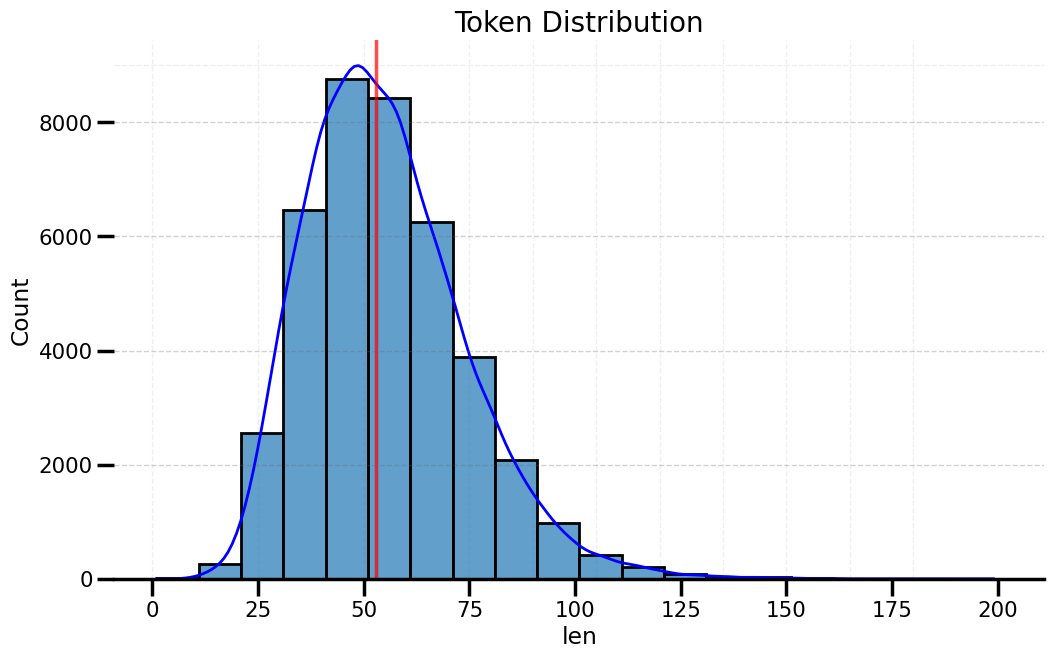

In [31]:
#sns.set_style('white',{'font.family':'NanumSquare'})
sns.set_context("poster", font_scale = 0.7, rc={"grid.linewidth": 5})

fig1, axes = plt.subplots(1,1, figsize=(12,7))
fig1.gca().spines['right'].set_visible(False)   # 오른쪽 테두리 제거
fig1.gca().spines['top'].set_visible(False)     # 위 테두리 제거
fig1.gca().spines['left'].set_visible(False)    # 왼쪽 테두리 제거

ax1 = sns.histplot(df, x='len', binwidth=10, alpha=0.7, kde=True,
                   line_kws={'lw':2} 
                   ## 'color':'b' 적용이 안되서 대안으로 아래 방식 활용
                   )
ax1.lines[0].set_color('b')
  
# 값의 폭을 10단위로 확인해봄 # bins=n 통해 bin 개수 조절 가능
ax1.set_title('Token Distribution', fontsize=20)

# y축 설정
plt.axhline(y=2000, color='#626774', linestyle='--', linewidth=1, alpha=0.3)
plt.axhline(y=4000, color='#626774', linestyle='--', linewidth=1, alpha=0.3)
plt.axhline(y=6000, color='#626774', linestyle='--', linewidth=1, alpha=0.3)
plt.axhline(y=8000, color='#626774', linestyle='--', linewidth=1, alpha=0.3)
plt.axhline(y=9000, color='#626774', linestyle='--', linewidth=1, alpha=0.1)

# x 축 설정
plt.axvline(x=0, color='#626774', linestyle='--', linewidth=1, alpha=0.1)
plt.axvline(x=25, color='#626774', linestyle='--', linewidth=1, alpha=0.1)
plt.axvline(x=50, color='#626774', linestyle='--', linewidth=1, alpha=0.1)
plt.axvline(x=75, color='#626774', linestyle='--', linewidth=1, alpha=0.1)
plt.axvline(x=90, color='#626774', linestyle='--', linewidth=1, alpha=0.1)
plt.axvline(x=105, color='#626774', linestyle='--', linewidth=1, alpha=0.1)
plt.axvline(x=120, color='#626774', linestyle='--', linewidth=1, alpha=0.1)
plt.axvline(x=135, color='#626774', linestyle='--', linewidth=1, alpha=0.1)
plt.axvline(x=150, color='#626774', linestyle='--', linewidth=1, alpha=0.1)
plt.axvline(x=165, color='#626774', linestyle='--', linewidth=1, alpha=0.1)
plt.axvline(x=180, color='#626774', linestyle='--', linewidth=1, alpha=0.1)

# 중위수 표시
plt.axvline(x=df['len'].median(), color='r', linestyle='-', linewidth=2.5, alpha=0.7)

- 추가적으로 확인 가능 요소 
> 추후 성능 확인 진행 후 token len과 성능 비교   

  - 유의미한지 
  - 영향이 있는지 상관분석

## Dictionary 생성 및 불용어 제외

**Dictionary 생성 및 token 개수 파악**

> Counter 생성자를 통해 중복된 데이터가 저장된 배열에서 각 원소가 몇 번씩 저장되었는지 저장된 객체를 얻어오겠다. 

In [34]:
# Counter 통해 중복된 데이터가 저장된 배열에서 각 원소가 몇 번씩 저장되었는지 확인
from collections import Counter

In [32]:
df.head(3)

,image,caption,token,len
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...,"[a, child, in, a, pink, dress, is, climbing, u...",72
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .,"[a, girl, going, into, a, wooden, building]",37
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .,"[a, little, girl, climbing, into, a, wooden, p...",48


In [40]:
words = df['token'].tolist()
#frequent = Counter(words).most_common()
#print(f'unique한 token의 개수 : {len(words)}')
#print(len(frequent))

TypeError: ignored

In [ ]:
# 형태소 단위 빈도 분석 (해당 방식은 str 기반으로 morphs를 추출, fequent 파악하는 방식)
# 변형 필요

#words = " ".join(df['token'].tolist())  # token을 list에 담음
#morphs = 
#frequent = Counter(words).most_common()

#print(f'unique word 개수 : {len(frequent)}')

-> 진행중 : https://github.com/MinsooKwak/cp2_share/blob/main/cp2_morphs.ipynb

-> 참고 : https://www.dinolabs.ai/295

살펴봐야할 내용 (스터디)

- https://wikidocs.net/182469
- https://velog.io/@fe26ming/%EB%94%A5%EB%9F%AC%EB%8B%9D-8%EC%9D%BC%EC%B0%A8
- https://han-py.tistory.com/271
- https://m.blog.naver.com/askif2/222024172658
- https://www.lucypark.kr/courses/2015-dm/text-mining.html


참조 : https://www.dinolabs.ai/295

DenseCap

https://tensorflow.blog/2016/04/21/densecap-fully-convolutional-localization-networks-for-dense-captioning/

github : https://github.com/jcjohnson/densecap